In [1]:
# To Do
# xgboost?

In [2]:
Author = 'Conrad'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from datetime import datetime
import time
import pytz
local_timezone = 'America/Los_Angeles'
from time import gmtime, strftime

from scipy import stats
import numpy as np
import pandas as pd
#from pandas.plotting import scatter_matrix
import xarray as xr
from pandas import Series
import seaborn as sns
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15.0, 8.0)

import yfinance as yf

from sklearn import preprocessing
#from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import maxabs_scale
from sklearn.preprocessing import Binarizer as binarizer

from sklearn.decomposition import FastICA, PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import cluster
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import mixture
                                  
from sklearn.metrics import mean_squared_error as rmse 
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import explained_variance_score as evs
from sklearn.metrics import r2_score as r_squared
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
                                  
        

In [3]:
# SET KEYLINE TIME RELATED PARAMETERS
calendar = {}
calendar['z_score_window'] = 252
calendar['regression_est_window'] = 400
calendar['sim_time'] = time.strftime('%x %X')
calendar['trim_pct'] = .01
calendar['ewa_halflife'] = 3

print(calendar['sim_time'])

11/29/23 14:33:15


In [4]:
# FUNCTION FOR TIME-SAFE Z-SCORES
def z_score(df,window = calendar['z_score_window']):
    window = calendar['z_score_window']
    rstd = df.rolling(window=window,min_periods=window).std()
    rmean = df.rolling(window=window,min_periods=window).mean()
    z = (df - rmean) / rstd
    z = z.dropna()
    return z

In [5]:
# FUNCTIONS FOR Re-Basing Returns & computing log returns from a price levels

def rebase_rets(input):
    output = pd.DataFrame(input).set_index(pd.DatetimeIndex(input.index))
    output = output.dropna()
    output = 1+output.cumsum()
    return output

def log_returns(df):
    df = np.log(df)
    df = df - df.shift(1)
    #df.index.name = None
    return df

def pct_returns(df):
    df = df.pct_change()
    return df

def generate_train_predict_calender(df, window_size):
    date_ranges = []
    index = df.index
    num_days = len(index)

    for i in range(0, num_days - window_size):
        #if i + window_size <= len(index):
        train_start_date = index[i]
        train_end_date = index[i + window_size - 1]
        prediction_date = index[i + window_size]
        date_ranges.append([train_start_date, train_end_date, prediction_date])

    return date_ranges


def apply_ewm(X, halflife):
    return X.ewm(halflife=halflife).mean()

In [88]:
def t_func_1(df,pred_col='predicted', actual_col='actual',new_col='perf'):
    t_conditions = [ df[pred_col] >= 0, df[pred_col] < 0 ]
    t_positions =  [ df[actual_col]*1,  df[actual_col]*-1 ]
    return np.select(t_conditions,t_positions, default=np.nan) # Apply trading logic here

def t_func_2(df,pred_col='predicted', actual_col='actual',new_col='perf'):
    t_conditions = [ df[pred_col] >= 0, df[pred_col] < 0 ]
    t_positions =  [ df[actual_col]*2,  df[actual_col]*0 ]
    return np.select(t_conditions,t_positions, default=np.nan) # Apply trading logic here

In [65]:
# Synch Indexes & Preprocess Features and Targets
spdr = ['SPY','XLK', 'XLF', 'XLV', 'XLY', 'XLP', 'XLE', 'XLI', 'XLB', 'XLU'] # XLRE????
#df_all = yf.download(spdr, start="1990-01-03", end="2024-08-06")['Adj Close'].dropna()
df_is = yf.download(spdr, start="2000-01-03", end="2016-08-05")['Adj Close'].dropna()
df_all = yf.download(spdr, start="2000-01-03", end="2066-08-05")['Adj Close'].dropna()

y_level = df_all['SPY']  # break out targets
y = log_returns(y_level)  # process as log returns

X_level = df_all.drop(['SPY'],axis=1)   # break out features
X_log_returns = log_returns(X_level).shift(1)  # Lagging all features 1 day 
X = z_score(X_log_returns,calendar['z_score_window']) # preprocess as z-scores

y = y.loc[X.index]

[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed


In [66]:
y

Date
2001-01-03    0.046917
2001-01-04   -0.010822
2001-01-05   -0.033187
2001-01-08    0.007710
2001-01-09   -0.002644
                ...   
2023-11-22    0.003853
2023-11-24    0.000615
2023-11-27   -0.001803
2023-11-28    0.000990
2023-11-29   -0.000704
Name: SPY, Length: 5763, dtype: float64

In [9]:
from sklearn.preprocessing import FunctionTransformer
halflife = 3

# Create a pipeline with FunctionTransformer and RandomForestRegressor
pipe = Pipeline([('ewm', FunctionTransformer(apply_ewm, kw_args={'halflife': halflife}))])
#pipe.fit_transform(X)

In [101]:
def sim_stats(regout_list,sweep_tags,author='CG'):
    df = pd.DataFrame()
    for n, testlabel in enumerate(sweep_tags):
        reg_out = regout_list[n]
        df.loc['mean',testlabel] = mean = 252*reg_out.perf_ret.mean()
        df.loc['stdev',testlabel] = std = (np.sqrt(252))*reg_out.perf_ret.std()
        df.loc['sharpe',testlabel] = mean / std
        df.loc['pos_bet_ratio',testlabel] = np.sum(np.isfinite(reg_out['predicted']) & (reg_out['predicted'] > 0)) / np.sum(np.isfinite(reg_out['predicted']))

        df.loc['rmse',testlabel] = np.sqrt(rmse(reg_out.predicted,reg_out.actual))
        df.loc['mae',testlabel] = mae(reg_out.predicted,reg_out.actual)
        df.loc['evs',testlabel] = evs(reg_out.predicted,reg_out.actual)
        df.loc['r2',testlabel] = r_squared(reg_out.predicted,reg_out.actual)
        df.loc['benchmark return',testlabel] = bench_ret = 252*reg_out.actual.mean()
        df.loc['benchmark std',testlabel] = bench_std = (np.sqrt(252))*reg_out.actual.std()
        df.loc['benchmark sharpe',testlabel] = bench_ret / bench_std
        df.loc['beg_pred',testlabel] = min(reg_out.predicted.index).date()
        df.loc['end_pred',testlabel] = max(reg_out.predicted.index).date()
        df.loc['train window',testlabel] = window=calendar['regression_est_window'] 
        df.loc['z_score_window',testlabel] = calendar['z_score_window']
        df.loc['sim_time',testlabel] =  datetime.now(pytz.timezone(local_timezone)).strftime("%x %-I:%-m%p") 
        df.loc['author',testlabel] = author
    return df

In [40]:
# ROLL FORWARD SIMULATOR - 1) TRAIN UP TO T-1, 2) PREDICT AT T, 3) TRADE

def Simulate(X,y,window=calendar['regression_est_window'],pipe_steps={},dims_dict={}):    
    regout = pd.DataFrame(index=y.index)
    
    date_ranges = generate_train_predict_calender(X, window)
    
    pipe = Pipeline(steps=pipe_steps)
    pipe.set_params(**dims_dict)

    for n,dates in enumerate(date_ranges):

        start_training, end_training, prediction_date = dates[0], dates[1],dates[2]

        fit_X = X[start_training:end_training]
        fit_y = y[start_training:end_training]
        pred_X = X[prediction_date:prediction_date]
        
        pipe.fit(fit_X,fit_y)
        #print('pred_date',prediction_date,'features = ',pipe.named_steps['eln'].n_features_in_)
        #regout.loc[prediction_date,'expl_var'] = pipe.named_steps['pca'].explained_variance_ratio_[2]
        #regout.loc[prediction_date,'coeff_1st_dim'] = pipe.named_steps['reg'].coef_[0]
                
        regout.loc[prediction_date,'predicted'] = pipe.predict(pred_X)
    
    return regout.dropna()

In [76]:
# Simulate Dim Reduction -> Linreg
last_printed_time = datetime.now()
regout_list = []

## Dim Reduction
pca = PCA()
clust = cluster.FeatureAgglomeration(n_clusters=4)
kbest = SelectKBest(chi2, k=20)

## Estimators
ols = LinearRegression()
eln = ElasticNet()
lasso = Lasso(alpha=0.1)
ridge = Ridge(alpha=.5)

Results_xr = xr.Dataset()
Results_df = pd.DataFrame()

max_sweep_n = 9
sweep_n = [n+1 for n in range(max_sweep_n)]
pca_tags = sweep_tags = ['pca'+str(n)+'reg' for n in sweep_n]

for n, test_param in enumerate(sweep_n):
    pipe_steps=[('pca', PCA()), ('ols', LinearRegression())]
    dims_dict = {'pca__n_components':test_param,'ols__fit_intercept':True}
    
    regout_df = Simulate(X,y,window=calendar['regression_est_window'],pipe_steps=pipe_steps,dims_dict=dims_dict)
    regout_df['actual'] = y[regout_df.predicted.index].dropna()
    regout_df['perf_ret'] = t_func_1(regout_df,pred_col='predicted', actual_col='actual',new_col = 'perf') # Enter Trading Func
    regout_df['perf_mtm'] = regout_df['perf_ret'].cumsum()
    regout_df['es_mtm'] = regout_df['actual'].cumsum()
    regout_list.append(regout_df)
    
    sim_xr = regout_df.to_xarray().expand_dims(Tag=[sweep_tags[n]])    
    Results_xr = xr.merge([Results_xr,sim_xr])

    

    current_time = datetime.now()
    time_elapsed = current_time - last_printed_time
    last_printed_time = current_time
    print(sweep_tags[n],'sim time = ',time_elapsed)

Results_df = sim_stats(regout_list,sweep_tags,author='CG')


pca1reg sim time =  0:00:04.692231
pca2reg sim time =  0:00:04.623376
pca3reg sim time =  0:00:04.610254
pca4reg sim time =  0:00:04.595694
pca5reg sim time =  0:00:04.601882
pca6reg sim time =  0:00:04.668775
pca7reg sim time =  0:00:04.716657
pca8reg sim time =  0:00:04.725927
pca9reg sim time =  0:00:04.713829


In [77]:
Results_xr

<xarray.Dataset>
Dimensions:    (Tag: 9, Date: 5363)
Coordinates:
  * Tag        (Tag) object 'pca1reg' 'pca2reg' ... 'pca8reg' 'pca9reg'
  * Date       (Date) datetime64[ns] 2002-08-12 2002-08-13 ... 2023-11-29
Data variables:
    predicted  (Tag, Date) float64 -0.0005964 -0.00109 ... 0.001164 0.0009777
    actual     (Tag, Date) float64 -0.007366 -0.01838 ... 0.0009896 -0.0007037
    perf_ret   (Tag, Date) float64 0.007366 0.01838 ... 0.0009896 -0.0007037
    perf_mtm   (Tag, Date) float64 0.007366 0.02574 -0.01014 ... 0.9346 0.9339
    es_mtm     (Tag, Date) float64 -0.007366 -0.02574 0.01014 ... 2.01 2.01

In [78]:
Results_df

,pca1reg,pca2reg,pca3reg,pca4reg,pca5reg,pca6reg,pca7reg,pca8reg,pca9reg
mean,0.059827,0.067294,0.051055,0.049466,0.052947,0.048464,0.064607,0.0323,0.043882
stdev,0.191398,0.191388,0.191408,0.191409,0.191406,0.191411,0.191392,0.191424,0.191415
sharpe,0.312578,0.351609,0.266732,0.258431,0.276623,0.253195,0.337562,0.168736,0.229253
rmse,0.012054,0.012042,0.012074,0.012099,0.012107,0.012136,0.012141,0.012164,0.012163
mae,0.007836,0.007841,0.007863,0.007896,0.007918,0.007932,0.007948,0.007994,0.007994
evs,-96.691432,-57.732769,-51.399836,-42.235362,-35.806457,-33.608362,-29.050118,-25.728273,-24.143063
r2,-96.695288,-57.734486,-51.401144,-42.236595,-35.80747,-33.609367,-29.051079,-25.729008,-24.143685
benchmark return,0.094425,0.094425,0.094425,0.094425,0.094425,0.094425,0.094425,0.094425,0.094425
benchmark std,0.191342,0.191342,0.191342,0.191342,0.191342,0.191342,0.191342,0.191342,0.191342
benchmark sharpe,0.493489,0.493489,0.493489,0.493489,0.493489,0.493489,0.493489,0.493489,0.493489


In [31]:
Results_xr#.rand_perf.mean(dim='Date').to_dataframe()
#sim_stats(reg_out,testlabel,author='CG')

<xarray.Dataset>
Dimensions:    (Tag: 9, Date: 3521)
Coordinates:
  * Tag        (Tag) object 'pca1reg' 'pca2reg' ... 'pca8reg' 'pca9reg'
  * Date       (Date) datetime64[ns] 2002-08-12 2002-08-13 ... 2016-08-04
Data variables:
    predicted  (Tag, Date) float64 -0.0005964 -0.00109 ... 0.0009345 -0.000594
    actual     (Tag, Date) float64 -0.007366 -0.01838 ... 0.002918 0.001063
    perf_ret   (Tag, Date) float64 0.007366 0.01838 ... 0.002918 -0.001063
    perf_mtm   (Tag, Date) float64 0.007366 0.02574 -0.01014 ... 0.8363 0.8352
    es_mtm     (Tag, Date) float64 -0.007366 -0.02574 0.01014 ... 1.14 1.141

In [102]:
#pipe = Pipeline([('ewm', FunctionTransformer(apply_ewm, kw_args={'halflife': halflife}))])
regout_list = []
Results_xr = xr.Dataset()
Results_df = pd.DataFrame()
max_sweep_n = 5
sweep_n = [(n+1) for n in range(1,max_sweep_n)]
ewm_tags = sweep_tags = ['ewm_'+str(n)+'_reg_oos' for n in sweep_n]

for n, test_param in enumerate(sweep_n):
    
    pipe_steps=[('ewm', FunctionTransformer(apply_ewm, kw_args={'halflife': test_param})), 
                ('pca', PCA(n_components=2)),
                ('ols', LinearRegression(fit_intercept=True))]

    dims_dict = {} 
    
    regout_df = Simulate(X,y,window=calendar['regression_est_window'],pipe_steps=pipe_steps,dims_dict=dims_dict)
    regout_df['actual'] = y[regout_df.predicted.index].dropna()
    regout_df['perf_ret'] = t_func_2(regout_df,pred_col='predicted', actual_col='actual',new_col = 'perf') # Enter Trading Func
    regout_df['perf_mtm'] = regout_df['perf_ret'].cumsum()
    regout_df['es_mtm'] = regout_df['actual'].cumsum()
    regout_list.append(regout_df)
    
    sim_xr = regout_df.to_xarray().expand_dims(Tag=[sweep_tags[n]])    
    Results_xr = xr.merge([Results_xr,sim_xr])

    

    current_time = datetime.now()
    time_elapsed = current_time - last_printed_time
    last_printed_time = current_time
    print(sweep_tags[n],'sim time = ',time_elapsed)

Results_df = sim_stats(regout_list,sweep_tags,author='CG')
   

ewm_2_reg_oos sim time =  0:14:38.019939
ewm_3_reg_oos sim time =  0:00:06.241458
ewm_4_reg_oos sim time =  0:00:06.157976
ewm_5_reg_oos sim time =  0:00:06.175592


In [103]:
#Results_xr
Results_df

,ewm_2_reg_oos,ewm_3_reg_oos,ewm_4_reg_oos,ewm_5_reg_oos
mean,0.161769,0.177181,0.161109,0.146863
stdev,0.277108,0.276504,0.270998,0.26956
sharpe,0.583775,0.640787,0.594501,0.544825
pos_bet_ratio,0.577289,0.561439,0.545217,0.539437
rmse,0.012365,0.012524,0.012658,0.012779
mae,0.008156,0.008304,0.008427,0.008537
evs,-12.209989,-9.017886,-7.510812,-6.574292
r2,-12.210767,-9.01845,-7.511317,-6.574771
benchmark return,0.094425,0.094425,0.094425,0.094425
benchmark std,0.191342,0.191342,0.191342,0.191342


In [98]:
sweep_tags

['ewm_2_reg_oos', 'ewm_3_reg_oos', 'ewm_4_reg_oos', 'ewm_5_reg_oos']

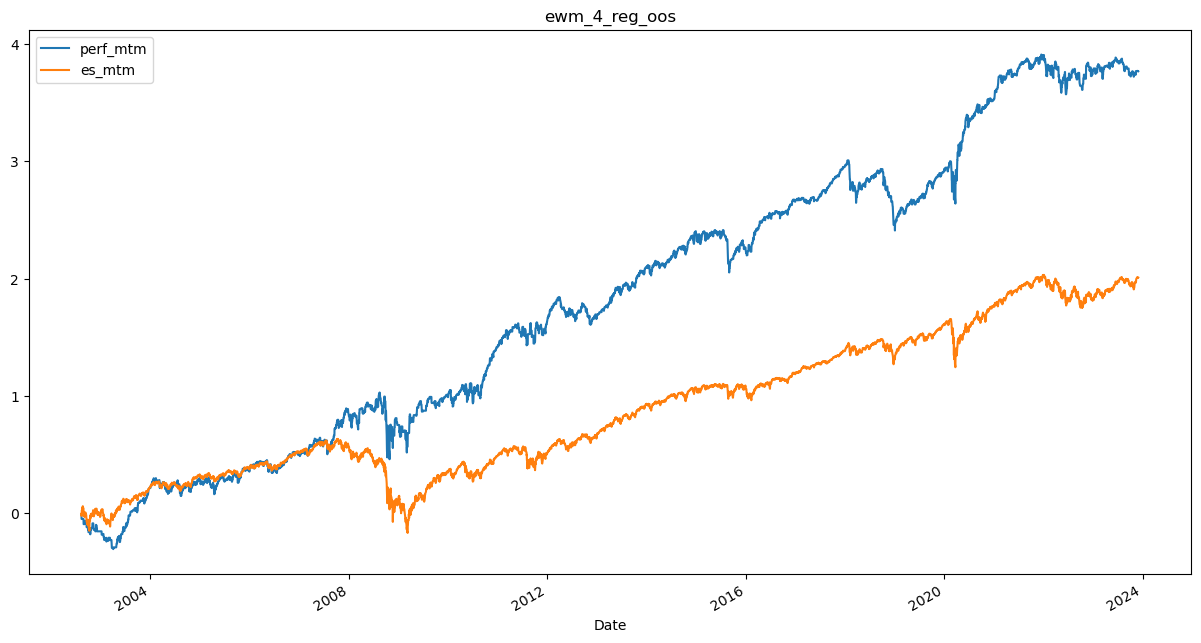

In [100]:
ttt = Results_xr.sel(Tag=[sweep_tags[1]]).to_dataframe()
ttt.reset_index(level='Tag', inplace=True)
ttt.loc[:,['perf_mtm','es_mtm']].plot(title=sweep_tags[2])
plt.show()

In [104]:
#Slice results by in and out of sample
test_df = pd.DataFrame()
IS = slice("2001-07-26","2016-08-04")  #  In-Sample 
OOS = slice("2016-08-05", "2023-11-27")  #  Out of Sample
def xr_2_df_by_slice(tag, drange, label):
    xr_out = Results_xr.sel(Tag=[tag],Date=drange).to_dataframe()
    xr_out.reset_index(level='Tag', inplace=True)
    return sim_stats(xr_out,label,author='CG')

tag = 'ewm_3_reg_oos'
oos_df = xr_2_df_by_slice(tag, OOS,'OOS_'+tag)
is_df = xr_2_df_by_slice(tag, IS,'IS_'+tag)
is_oos_df = pd.concat([oos_df, is_df],axis=1)
is_oos_df

                           


KeyError: 0

In [ ]:
Results_xr.sel(Date=IS)
#Results_xr.sel(Date=OOS)
#Results_xr.sel(Date=OOS).mean(dim='Date').mean(dim='Tag')
#Results_xr.sel(Date=OOS).mean(dim='Date').mean(dim='Tag')

In [ ]:
Results_xr

In [ ]:
#for tag in sweep_tags:


xr_2_df_by_slice(Tag = 'pca3reg', Date=OOS)

In [ ]:
#Results_xr['mtm'].plot.line(x='Date')
Results_xr['mtm'].sel(Date=slice("2016-08-06", "2023-11-27")).cumsum.plot()#.line(x='Date')
plt.title('K-Best with F-Test then Linreg with N Features passed')
plt.ylabel('Cummulative Return')
plt.show()

In [ ]:
# Simulate Feature Selection
from sklearn.feature_selection import SelectKBest, chi2, f_regression
kbest = SelectKBest(chi2, k=20)

max_sweep_n = 2
sweep_n = [n+1 for n in range(max_sweep_n)]
kbest_tags = sweep_tags = ['kbest'+str(n)+'reg' for n in sweep_n]

Results_kbest_xr = xr.Dataset()
Summary_list = []

for n, test_param in enumerate(sweep_n):
    pipe_steps=[('kb', SelectKBest(k=test_param,score_func=f_regression)), ('ols', LinearRegression(fit_intercept=True))]
    dims_dict = {}

    regout_df = Simulate(X,y,window=calendar['regression_est_window'],pipe_steps=pipe_steps,dims_dict=dims_dict)
    Results_df = pd.concat([Results_df,sim_stats(regout_df,sweep_tags[n])],axis=1)
    sim_xr = regout_df.to_xarray().expand_dims(Tag=[sweep_tags[n]])    
    Results_xr = xr.merge([Results_xr,sim_xr])
 

In [ ]:
Results_xr['mtm'].sel(Tag=pca_tags).plot.line(x='Date')
plt.title('K-Best with F-Test then Linreg with N Features passed')
plt.ylabel('Cummulative Return')
plt.show()

In [ ]:
Results_df.T['mean'].plot()


In [ ]:
# estimators = [
#     ("OLS", LinearRegression()),
#     ("Theil-Sen", TheilSenRegressor(random_state=42)),
#     ("RANSAC", RANSACRegressor(random_state=42)),
# ]

ols =  LinearRegression(fit_intercept=True)
ridge = Ridge(alpha=.9,fit_intercept=True)
eln = ElasticNet(random_state=0,alpha=.5,l1_ratio=.5,fit_intercept=True,selection='random')

learners = [ols, ridge, eln]
learner_tags = sweep_tags = [str(x) for x in learners]


for n, learner_tested in enumerate(learners):
    pipe_steps=[('pca', PCA(n_components=2)), (learner_tags[n], learners[n])]
    dims_dict = {}

    regout_df = Simulate(X,y,window=calendar['regression_est_window'],pipe_steps=pipe_steps,dims_dict=dims_dict)
    Results_df = pd.concat([Results_df,sim_stats(regout_df,sweep_tags[n])],axis=1)
    sim_xr = regout_df.to_xarray().expand_dims(Tag=[sweep_tags[n]])    
    Results_xr = xr.merge([Results_xr,sim_xr])





In [ ]:
Results_xr['mtm'].sel(Tag=learner_tags).plot.line(x='Date')
plt.title('K-Best with F-Test then Linreg with N Features passed')
plt.ylabel('Cummulative Return')
plt.show()

In [ ]:
Results_xr['mtm'].sel(Tag=kbest_tags).plot.line(x='Date')
plt.title('K-Best with F-Test then Linreg with N Features passed')
plt.ylabel('Cummulative Return')
plt.show()

In [ ]:
Results_df

In [ ]:
# Function to generate random guess bets with 50% up and 50% down
# Returns a,b : a = regression metrics and b = df of out of sample predictions and targets
def random_bets(max_trials=50):
    rand_results=pd.DataFrame()
    rand_grets=pd.DataFrame()
    for t in range(max_trials):
        tags = 'Ramdom ' + str(t)
        X_bench = pd.DataFrame(np.random.choice([1,-1],size=(len(y.index),1)),columns=['Random'],index=y.index)
        rand_out = rreg(X_bench,y,drop_pred_indercept = False)
        rand_trade_out, rand_oos  = trule(rand_out)
        col_rand_results = regmetrics(rand_out,rand_trade_out,'tags')
        
        rand_results[tags] = col_rand_results['tags']
        rand_grets[tags] = rand_oos['strat_ret']
    return rand_results, rand_grets

In [ ]:
# DATA ANALYSIS - VIEW CORRELATION PROPERTIES BETWEEN SPY AND EACH OF ITS SECTOR COMPONENTS
import seaborn as sns
corr = dl.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(corr, mask=mask, square=True, annot=True, cmap='RdBu')
ax.get_figure().savefig('correl.png')



In [ ]:
import numpy as np
from sklearn import datasets, cluster
digits = datasets.load_digits()
images = digits.images
X = np.reshape(images, (len(images), -1))
agglo = cluster.FeatureAgglomeration(n_clusters=32)
agglo.fit(X)
X_reduced = agglo.transform(X)
print(X_reduced.shape,X.shape)

In [ ]:
#
#  this is the end of testing - the rest are summary / diagnostics, some of which run very slowly
#

In [ ]:
# COMPUTE N RANDOM STRATEGIES (50% up 50% down guess) AND GRAPH PERFOMANCE
a , Rand_Rets = random_bets(100)
c = rebase_rets(Rand_Rets)
print("Average Return when guessing = ", a.T['return'].mean())
c.plot()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [ ]:
# Classify the results into Up vs Down and then compute Confusion Matrix and Classification Report
#binarizer.__init__(threshold=0.0,copy=True)  # get an instance of the class
binarizer = preprocessing.Binarizer().fit(X)
Xbin = pd.DataFrame(binarizer.fit_transform(gretsX),index=gretsX.index)
ybin = pd.DataFrame(y,index=gretsX.index)
ybin = pd.DataFrame(binarizer.transform(ybin),index=ybin.index)
class_names = ['up','down']
for col in Xbin.columns:
    print(col)
    print(classification_report(ybin,Xbin[col],target_names=class_names))
    #print(col)
    #test = Xbin[col]
    #print(test.tail)
    cfm = confusion_matrix(ybin,Xbin[col])
    print(cfm)
    plt.figure()
    plot_confusion_matrix(cfm, classes=class_names,
                      title='Confusion matrix, Need Title')
    
 

In [ ]:
# Classify the Random results into Up vs Down and then compute Confusion Matrix and Classification Report
a , random_rets = random_bets(5)

Xrandbin = pd.DataFrame(binarizer.transform(random_rets),index=random_rets.index)
ybin = pd.DataFrame(y,index=random_rets.index)
ybin = pd.DataFrame(binarizer.transform(ybin),index=ybin.index)
for col in Xrandbin.columns:
    print(classification_report(ybin,Xrandbin[col],target_names=class_names))
    cfm = confusion_matrix(ybin,Xrandbin[col])
    print(cfm)
    plt.figure()
    plot_confusion_matrix(cfm, classes=class_names,
                      title='Confusion matrix, Need Title')


In [ ]:
#RESULTS - GRAPH RECOMMENDED MODEL AGAINST NON-PCA BENCHMARK, SPY, AND NON-SCORED FEATURES
final_graph = rebase_rets(pd.concat([gretsX['DL_PCA 2'], gretsXz['DLZ_PCA 2'],Regg_Rets['Non-PCA_Benchmark'],spy], axis=1, join='inner').dropna())
final_graph.plot()
figg = plt.gcf()
figg.savefig('final_graph.png')

In [ ]:
final_table = pd.concat([resultsX['DL_PCA 2'], resultsXz['DLZ_PCA 2']], axis=1, join='inner').dropna()

final_table

In [ ]:
from sklearn.linear_model import *

# Get all names in the module
all_names = dir(linear_model)

# Filter out classes from the names
#model_names = [name for name in all_names if isinstance(getattr(linear_model, name), type)]

model_names = [getattr(linear_model, name) for name in all_names if
                     isinstance(getattr(linear_model, name), type) and
                     issubclass(getattr(linear_model, name), RegressorMixin)]

# Print the list of model names
print(model_names)

sweep_results = pd.DataFrame(columns=model_names)


for learner in model_names:
    for n,dates in enumerate(date_ranges[:5]):
        start_training, end_training, prediction_date = dates[0], dates[1],dates[2]
        fit_X = X[start_training:end_training]
        fit_y = y[start_training:end_training]
        pred_X = X[prediction_date:prediction_date]
        
        learner.fit(fit_X, fit_y)
        preds = learner.predict(pred_X)
        sweep_results.loc[prediction_date,lerner] = learner.predict(pred_X)
        

sweep_results    
    
    

In [ ]:
from sklearn.linear_model import *
from sklearn.base import RegressorMixin
import inspect
import pandas as pd

# Get all names in the module
all_names = dir(linear_model)

# Filter out regression models from the names
regression_models = [
    getattr(linear_model, name) for name in all_names if
    isinstance(getattr(linear_model, name), type) and
    issubclass(getattr(linear_model, name), RegressorMixin) and
    len(inspect.signature(getattr(linear_model, name)).parameters) <= 2
]

# Print the list of regression model objects
print(regression_models)

sweep_results = pd.DataFrame(columns=[model.__name__ for model in regression_models])

for learner in regression_models:
    print(learner)
    for n, dates in enumerate(date_ranges[:5]):
        start_training, end_training, prediction_date = dates[0], dates[1], dates[2]
        fit_X = X[start_training:end_training]
        fit_y = y[start_training:end_training]
        pred_X = X[prediction_date:prediction_date]

        # Instantiate the learner
        model_instance = learner()

        # Fit the model
        try:
            model_instance.fit(fit_X, fit_y)

            # Predict and store the result
            preds = model_instance.predict(pred_X)
            sweep_results.loc[prediction_date, model_instance.__class__.__name__] = preds

        except ValueError as e:
            print(f"Skipped model {learner.__name__} due to error: {e}")

sweep_results


In [ ]:
regression_models

In [ ]:
# Define the time range to slice the dataset
start_date = "2023-01-03"
end_date = "2023-01-07"

# Slice the dataset by the specified time range
subset_ds = xr.sel(time=slice(start_date, end_date))

# Calculate the cumulative sum along the time dimension
cumulative_sum = subset_ds['data'].cumsum(dim='time')

# Plot the results
plt.figure(figsize=(10, 6))
cumulative_sum.plot.line(marker='o')

plt.title('Cumulative Sum of Data from {} to {}'.format(start_date, end_date))
plt.xlabel('Time')
plt.ylabel('Cumulative Sum')
plt.grid(True)
plt.show()


In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create a sample time series dataset
times = pd.date_range("2023-01-01", "2023-01-10", freq="D")
data_values = np.random.rand(len(times))

ds = xr.Dataset(
    {"data": (("time",), data_values)},
    coords={"time": times},
)

# Define the time range to slice the dataset
start_date = "2023-01-03"
end_date = "2023-01-07"

# Slice the dataset by the specified time range
subset_ds = ds.sel(time=slice(start_date, end_date))

# Calculate the cumulative sum along the time dimension
cumulative_sum = subset_ds['data'].cumsum(dim='time')

# Plot the results
plt.figure(figsize=(10, 6))
cumulative_sum.plot.line(marker='o')

plt.title('Cumulative Sum of Data from {} to {}'.format(start_date, end_date))
plt.xlabel('Time')
plt.ylabel('Cumulative Sum')
plt.grid(True)
plt.show()


In [ ]:
Results_xr['predicted'].cumsum(dim='Date').plot.line(marker='o')

In [ ]:
Results_xr['predicted'].cumsum(dim='Date').plot.line(marker='o', label='Cumulative Sum')

In [ ]:
#Results_xr['rand_perf'].mean(dim='Tag').cumsum(dim='Date').plot.line(x='Date')
Results_xr['rand_perf'].cumsum(dim='Date').plot.line(x='Date')

In [ ]:
df = Results_xr['predicted'].cumsum(dim='Date').to_dataframe().unstack()

df.columns = df.columns.get_level_values(1)#['2023-11-28']
df['2023-11-28'].mean()

In [ ]:
f=Results_xr.sel(Date=slice("2016-08-06", "2023-11-27")).predicted.cumsum(axis=1).mean(axis=1)

In [ ]:
r=Results_xr.sel(Date=slice("2016-08-06", "2023-11-27")).rand_perf.cumsum(axis=1).mean(axis=1)

In [ ]:
f=Results_xr.sel(Date=slice("2016-08-06", "2023-11-27"),Tag='pca1reg').predicted#.mean(axis=1)
# r=Results_xr.sel(Date=slice("2016-08-06", "2023-11-27")).rand_perf
# (f-r).mean()
data = f.to_dataframe()['predicted']

In [ ]:
r.to_dataframe().T

In [ ]:
regout.loc[regout['predicted'].dropna().index,'random'] = np.random.permutation(regout['predicted'].dropna())

In [ ]:
permuted_means = np.mean(np.random.shuffle(data.copy()) for _ in range(100))
permuted_means

In [ ]:
import numpy as np

# Assuming you have an array 'data' that you want to permute
# Replace this with your actual data
#data = np.array([1, 2, 3, 4, 5])

# Number of permutations
num_permutations = 100

# Generate 100 permuted arrays and calculate the mean for each
permuted_means = np.mean([np.random.permutation(data).mean() for _ in range(num_permutations)])

print(f"Overall mean of permuted means: {permuted_means}")


In [ ]:
test_df = pd.DataFrame(data={'price':[100,110,121]})
test_df['logret'] = log_returns(test_df['price'])

In [ ]:
test_df

In [ ]:
test_df['Cumulative Log Returns'] = np.log1p(test_df['logret']).cumsum()
test_df

In [ ]:

test_df = pd.DataFrame(data={'price':[100,110,121]})
test_df['gpt Log Return'] = np.log(test_df['price'] / test_df['price'].shift(1))
test_df['gpt cum'] = np.log1p(test_df['gpt Log Return']).cumsum()
test_df['new_price'] = np.expm1(test_df['gpt cum']) * 100
test_df

In [ ]:
import pandas as pd
import numpy as np

# Assuming you have a DataFrame with a column 'price'
test_df = pd.DataFrame(data={'price': [100, 110, 121]})

# Calculate log returns
test_df['gpt Log Return'] = np.log(test_df['price'] / test_df['price'].shift(1))

# Calculate cumulative log returns
test_df['gpt cum'] = np.log1p(test_df['gpt Log Return']).cumsum()

# Calculate new prices based on cumulative log returns
test_df['new_price'] = np.exp(test_df['gpt cum']) * 100

print(test_df)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create a DataFrame with a 'price' column
prices = [100, 110, 121, 132, 143]
dates = pd.date_range('2023-01-01', periods=len(prices))
df = pd.DataFrame(data={'price': prices}, index=dates)

# Calculate arithmetic returns
df['arith_return'] = df['price'].pct_change()

# Calculate log returns
df['log_return'] = np.log(df['price'] / df['price'].shift(1))
df['log_ret_diff'] = np.log(df['price']) - np.log( df['price'].shift(1))

# Accumulate returns over time
df['cum_arith_return'] = (1 + df['arith_return']).cumprod() - 1
df['cum_log_return'] = df['log_return'].cumsum()

# Plot the results
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['cum_arith_return'] * 100, label='Cumulative Arithmetic Return', marker='o')
plt.plot(df.index, df['cum_log_return'] * 100, label='Cumulative Log Return', marker='o')

plt.title('Comparison of Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
df